#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

# План проекта
**Загрузка и подготовка данных:**
* Загрузка недостающих библиотек;
* Чтение датасета и изменение индекса в дату;
* Работа с пустыми строками и дубликатами.

**Анализ данных:**
* Визуализация данных за  
 - весь предоставленный период,
 - месяц,
 - сутки,
 - час.
* Добавление данных, необходимых для обучения.

**Подготовка к обучению:**
* Создание функции для новых данных;
* Изменение типа данных;
* Деление датасета на трейн и тест выборки.

**Подбор гиперпараметров:**
* Подбираем для 4 моделей - 2 простые, 2 бустинг.

**Тестирование лучшей модели**

**Выводы**





## Загрузка и подготовка данных

Подгружаем библиотеку и методы:

In [1]:
#так как у меня не была установлена библиотека catboost в колабе, первым делом устанавливаю ее:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as ltb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


Загружаем датасет:
1. выбираем дату индексом.
2. сортируем в хронологическом порядке по дате и времени.
3. проверяем все ли верно.

In [2]:
data = pd.read_csv('/content/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

print(data.index.is_monotonic)
data.info()

print(data.head())

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32


<ipython-input-2-189a19041e6f>:4: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  print(data.index.is_monotonic)


In [3]:
data.isna().sum()
print('Датасет содержит', (data.duplicated().sum()), 'дубликата')

Датасет содержит 26415 дубликата


Пропущенных данных нет. Дубликаты оставляем - в одно и тоже время из разных аэропортов могло быть заказано такси.

## Анализ данных

Для начала скопируем датасет и сохраним для дальнейшего обучения:

In [4]:
data_teach=data.copy()
print(data_teach.head())

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32


Посмотрим на загруженность за весь период:

<Axes: xlabel='datetime'>

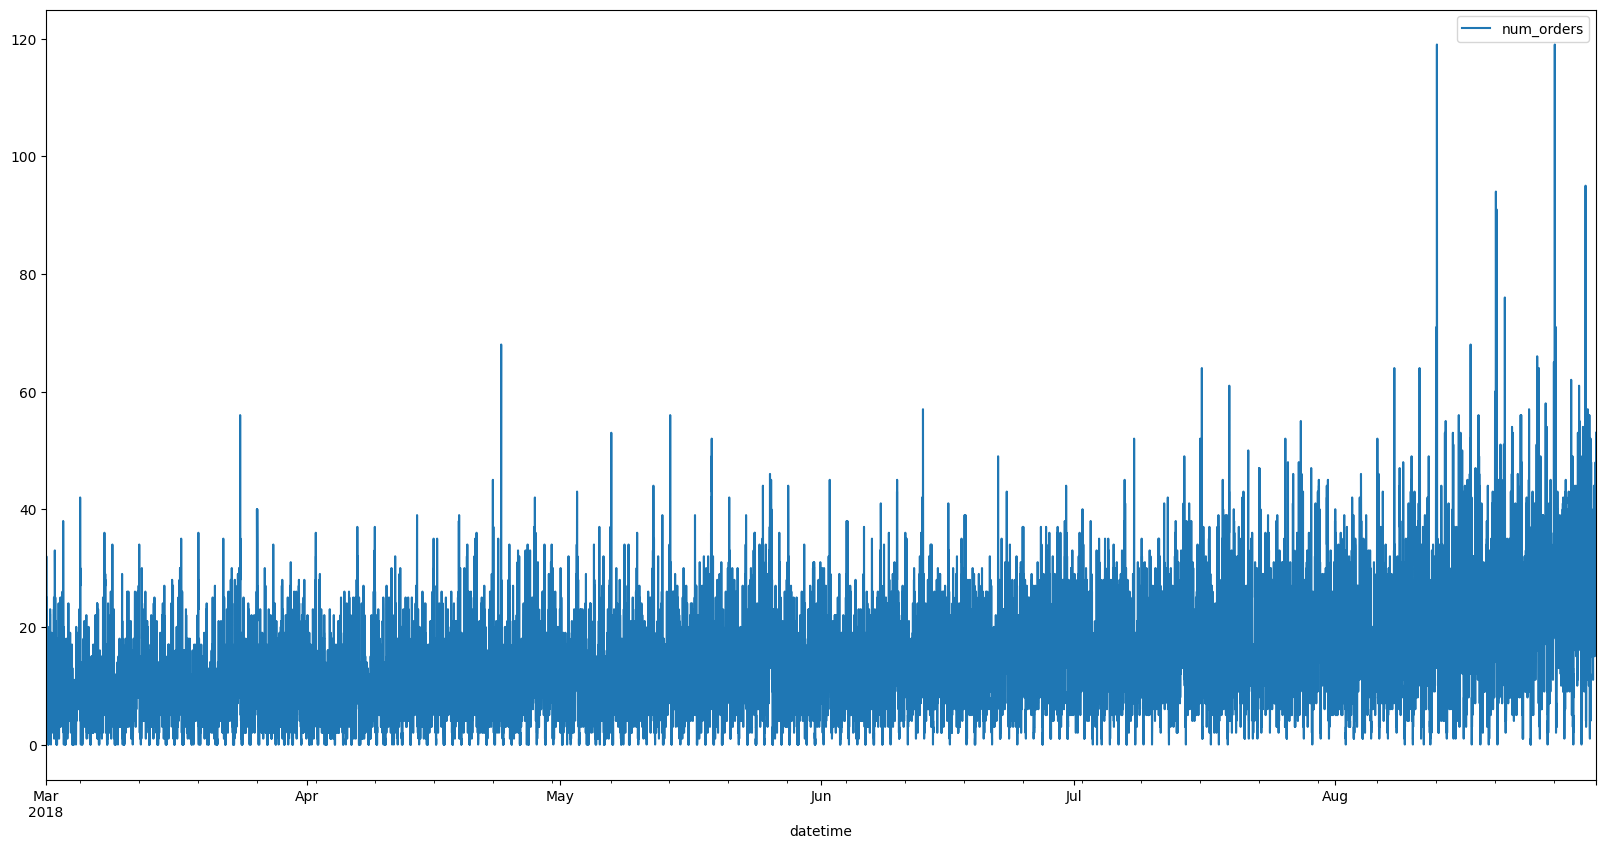

In [5]:
data.plot(figsize=(20, 10))

Посмотрим на загруженность по месяцам:

<Axes: xlabel='datetime'>

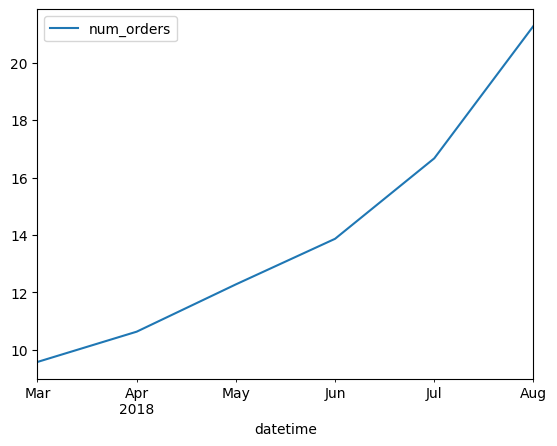

In [6]:
data_month=data.resample('1M').mean()
data_month.plot()

При шаге в месяц явно видно как загрузка растет к осени. Заменим интервал на час:

<Axes: xlabel='datetime'>

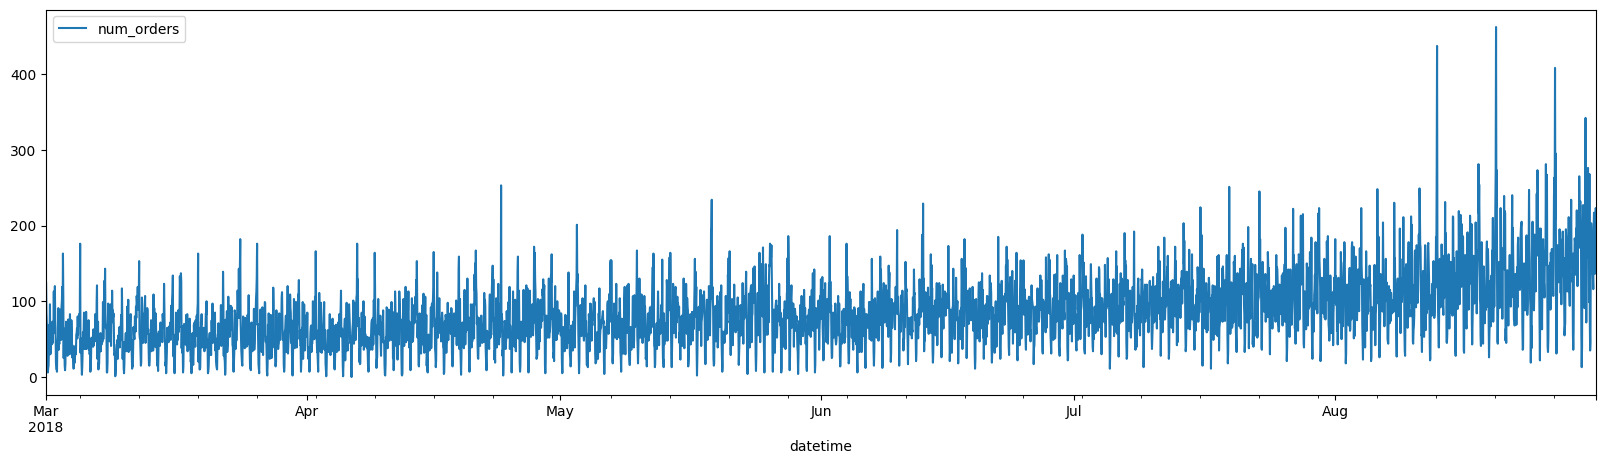

In [7]:
data= data.resample('1H').sum()
data.plot(figsize=(20, 5))

**Добавим данные:**
1. разность рядов,
2. среднее скользящее за 24 часа,
3. среднее количество заказов,
4. стандартное отклонение.

In [8]:
data['rolling_mean'] = data.rolling(24).mean()
data['shift'] = data['num_orders'].shift()
data['mean'] = data['num_orders'].rolling(24).mean()
data['std'] = data['num_orders'].rolling(24).std()

print(data.head(20))

                     num_orders  rolling_mean  shift  mean  std
datetime                                                       
2018-03-01 00:00:00         124           NaN    NaN   NaN  NaN
2018-03-01 01:00:00          85           NaN  124.0   NaN  NaN
2018-03-01 02:00:00          71           NaN   85.0   NaN  NaN
2018-03-01 03:00:00          66           NaN   71.0   NaN  NaN
2018-03-01 04:00:00          43           NaN   66.0   NaN  NaN
2018-03-01 05:00:00           6           NaN   43.0   NaN  NaN
2018-03-01 06:00:00          12           NaN    6.0   NaN  NaN
2018-03-01 07:00:00          15           NaN   12.0   NaN  NaN
2018-03-01 08:00:00          34           NaN   15.0   NaN  NaN
2018-03-01 09:00:00          69           NaN   34.0   NaN  NaN
2018-03-01 10:00:00          64           NaN   69.0   NaN  NaN
2018-03-01 11:00:00          96           NaN   64.0   NaN  NaN
2018-03-01 12:00:00          30           NaN   96.0   NaN  NaN
2018-03-01 13:00:00          32         

Удалим строки с неполными данными:

In [9]:
data = data.dropna()
print(data.head())

                     num_orders  rolling_mean  shift       mean        std
datetime                                                                  
2018-03-01 23:00:00          58     56.833333  113.0  56.833333  29.409650
2018-03-02 00:00:00          90     55.416667   58.0  55.416667  26.730404
2018-03-02 01:00:00         120     56.875000   90.0  56.875000  29.250511
2018-03-02 02:00:00          75     57.041667  120.0  57.041667  29.345734
2018-03-02 03:00:00          64     56.958333   75.0  56.958333  29.322019


Построим график:

<Axes: xlabel='datetime'>

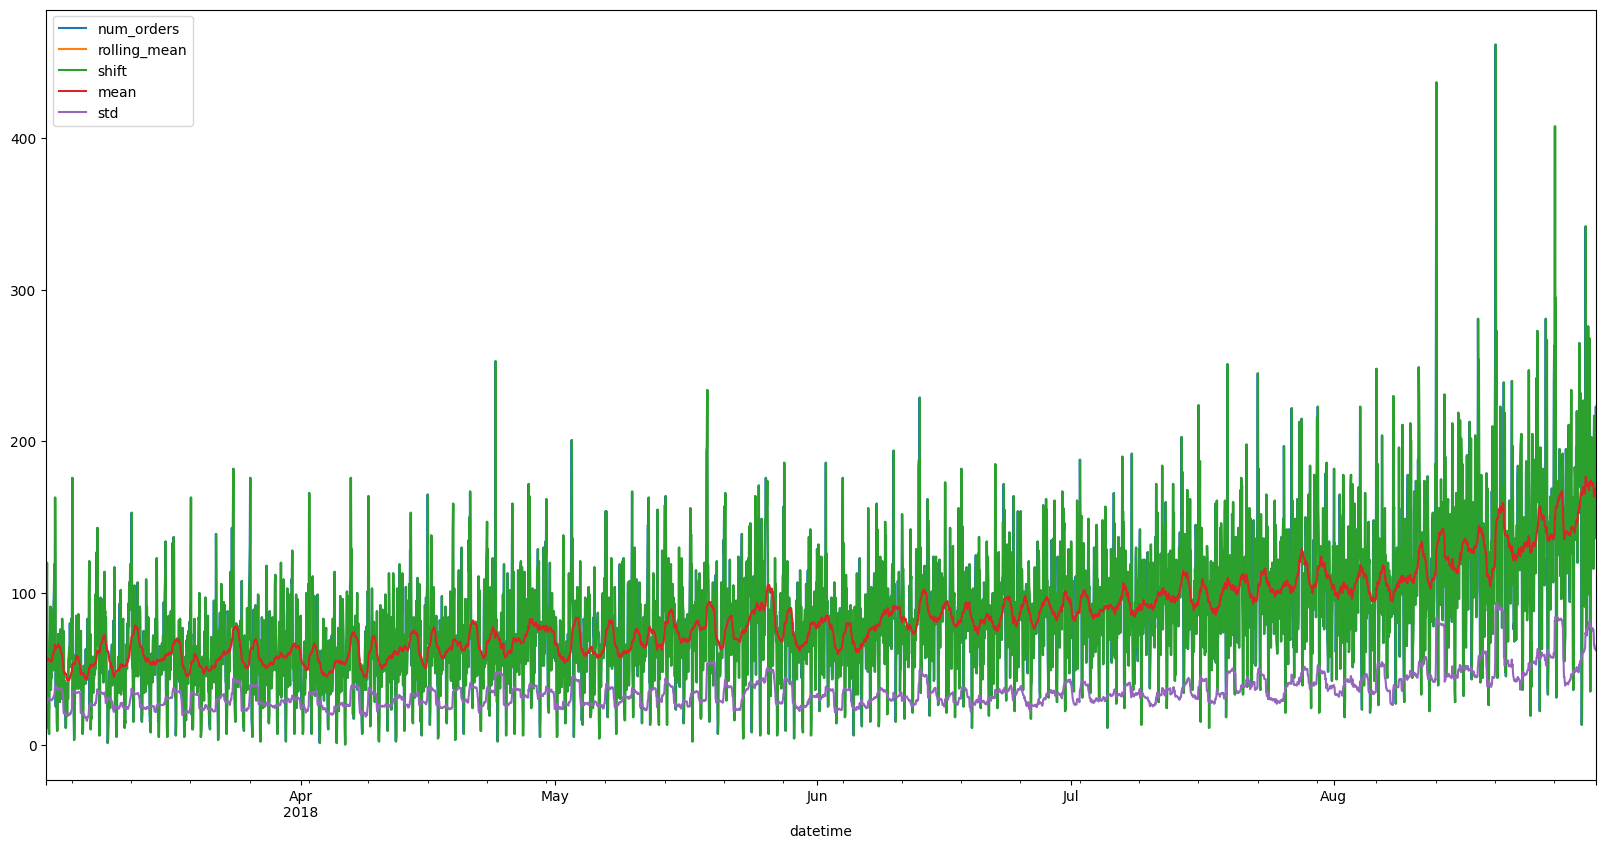

In [10]:
data.plot(figsize=(20, 10))

1. Старндартное отклонение стабильно.
2. Среднее тоже стабильно заказам.

Это хороший показатель.

Так как данных очень много - мы брали шаг 1 час - посмотрим тренд и сезонность за небольшой период. За неделю.

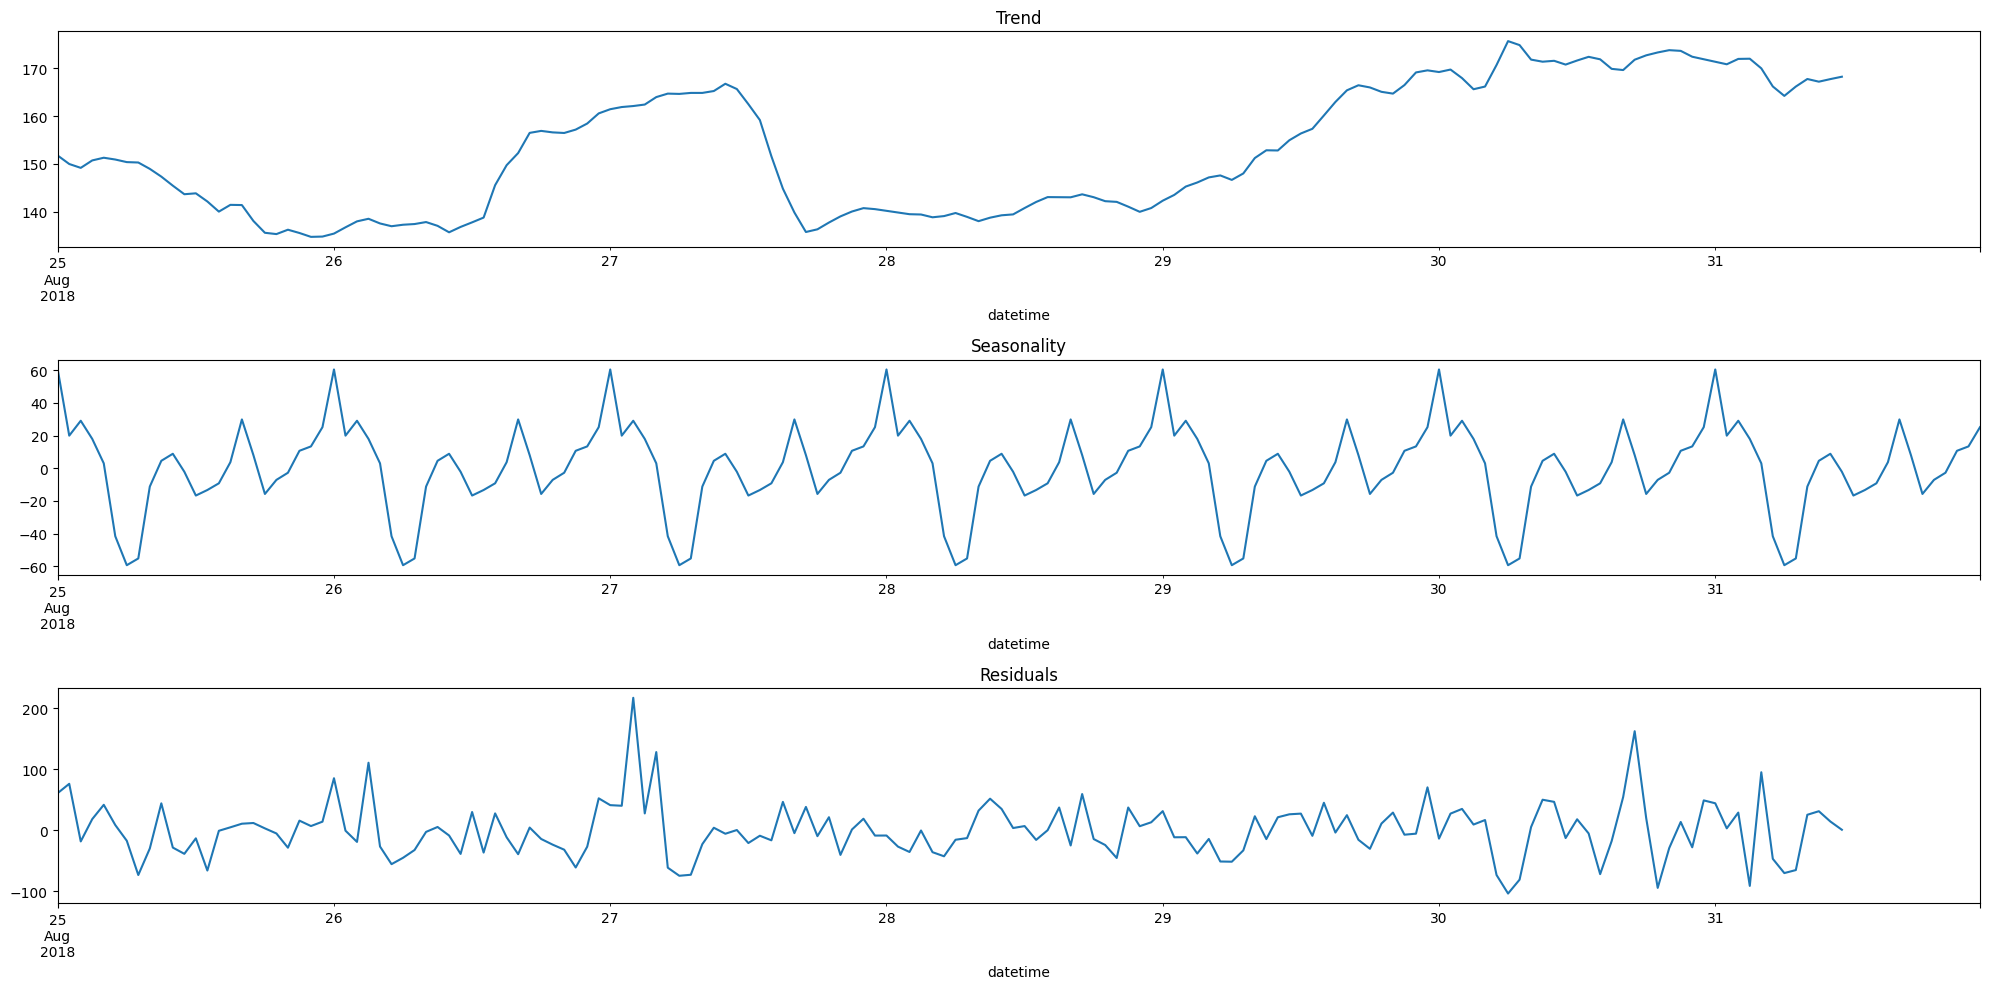

In [11]:
decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(20, 10))
plt.subplot(311)
decomposed.trend['2018-08-25':'2018-08-31'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-08-25':'2018-08-31'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid['2018-08-25':'2018-08-31'].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()
plt.show()

Что мы видим:
1. Судя по трендам, понедельник/четверг/пятница являются самыми загруженными днями для таксистов.
2. Сезонность показывает самый большой заказ такси ночью, небольшой подъем утром и в обед.

Посмотрим, что происходит в течение суток:

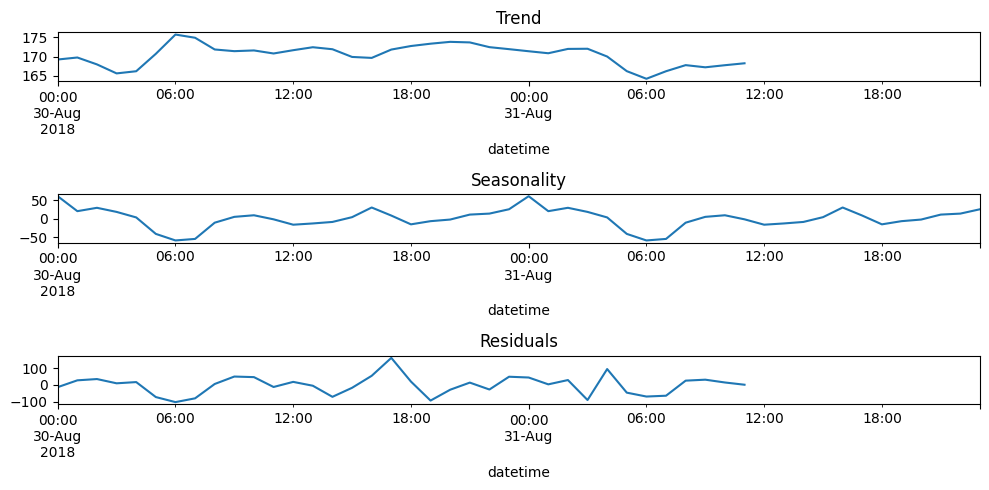

In [12]:
plt.figure(figsize=(10, 5))
plt.subplot(311)
decomposed.trend['2018-08-30':'2018-08-31'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-08-30':'2018-08-31'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid['2018-08-30':'2018-08-31'].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()
plt.show()

**Итог анализа данных:**
1. Добавила для последующего прогнозирования шаг в 1 час.
2. Определила среднее скользящее, разность врем.ряда, ст.отклонение, ср.значение. Судя по графику датасета данные постоянные и без вбросов. На них можно делать прогнозы.

## Подготовка к обучению

Напишем фунукцию для новых признаков - разобьем дату на столбцы: год, месяц, день, час. Для этого нам нужна изначальная
выборка без ст.отклонения, ср.скользящего и тп. Возьму **data_teach**.

In [13]:
print(data_teach.head(3))

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28


In [14]:
data_teach= data_teach.resample('1H').sum()


def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['year']=data_new.index.year
    data_new['month']=data_new.index.month
    data_new['day']=data_new.index.day
    data_new['hour']=data_new.index.hour
    #data['minute']=data.index.minute
    for lag in range(1, max_lag+1):
        data_new['lag_{}'.format(lag)]=data_new['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_new


data_new = make_features(data, 4, 4)
display(data_new.head())

data_new.info()

data_new = data_new.fillna(0)

<ipython-input-14-2258f2be0498>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


,num_orders,rolling_mean,shift,mean,std,year,month,day,hour,lag_1,lag_2,lag_3,lag_4
datetime,,,,,,,,,,,,,
2018-03-01 23:00:00,58,56.833333,113.0,56.833333,29.409650,2018,3,1,23,NaN,NaN,NaN,NaN
2018-03-02 00:00:00,90,55.416667,58.0,55.416667,26.730404,2018,3,2,0,58.0,NaN,NaN,NaN
2018-03-02 01:00:00,120,56.875000,90.0,56.875000,29.250511,2018,3,2,1,90.0,58.0,NaN,NaN
2018-03-02 02:00:00,75,57.041667,120.0,57.041667,29.345734,2018,3,2,2,120.0,90.0,58.0,NaN
2018-03-02 03:00:00,64,56.958333,75.0,56.958333,29.322019,2018,3,2,3,75.0,120.0,90.0,58.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4393 entries, 2018-03-01 23:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4393 non-null   int64  
 1   rolling_mean  4393 non-null   float64
 2   shift         4393 non-null   float64
 3   mean          4393 non-null   float64
 4   std           4393 non-null   float64
 5   year          4393 non-null   int64  
 6   month         4393 non-null   int64  
 7   day           4393 non-null   int64  
 8   hour          4393 non-null   int64  
 9   lag_1         4392 non-null   float64
 10  lag_2         4391 non-null   float64
 11  lag_3         4390 non-null   float64
 12  lag_4         4389 non-null   float64
dtypes: float64(8), int64(5)
memory usage: 480.5 KB


In [15]:
data_new['rolling_mean']=data_new['rolling_mean'].astype(int)
data_new['shift']=data_new['shift'].astype(int)
data_new['mean']=data_new['mean'].astype(int)
data_new['std']=data_new['std'].astype(int)
data_new['lag_1']=data_new['lag_1'].astype(int)
data_new['lag_2']=data_new['lag_2'].astype(int)
data_new['lag_3']=data_new['lag_3'].astype(int)
data_new['lag_4']=data_new['lag_4'].astype(int)

data_new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4393 entries, 2018-03-01 23:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   num_orders    4393 non-null   int64
 1   rolling_mean  4393 non-null   int64
 2   shift         4393 non-null   int64
 3   mean          4393 non-null   int64
 4   std           4393 non-null   int64
 5   year          4393 non-null   int64
 6   month         4393 non-null   int64
 7   day           4393 non-null   int64
 8   hour          4393 non-null   int64
 9   lag_1         4393 non-null   int64
 10  lag_2         4393 non-null   int64
 11  lag_3         4393 non-null   int64
 12  lag_4         4393 non-null   int64
dtypes: int64(13)
memory usage: 480.5 KB


Разделим датасет на тренировочную и тестовую выборки:

In [16]:
train, test = train_test_split(data_new, shuffle=False, test_size=0.1)

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

for i in [train, test]:
    print(i.shape)

2018-03-01 23:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00
(3953, 13)
(440, 13)


Посмотрим качество прогноза. Выбираю способ пронозирования предыдущим значением ряда. Способ с константом дает большую погрешность.

In [17]:
print('Среднее количество такси в час:', test['num_orders'].mean())
predict_previous = test.shift()
predict_previous.iloc[0]=train.iloc[-1]

print('MAE:', mean_absolute_error(test, predict_previous))
print('То есть 15,8%. Хороший показатель!')

Среднее количество такси в час: 139.56136363636364
MAE: 21.305069930069934
То есть 15,8%. Хороший показатель!


Теперь разделим выборки на признаки и целевой признак:

In [18]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

for i in [features_train, target_train, features_test, target_test]:
    print(i.shape)

(3953, 12)
(3953,)
(440, 12)
(440,)


### Подбираем модель по гиперпараментрам.

Чтобы модель не начала принимать тренировочную выборку за тестовую воспользуемся:

In [19]:
tscv = TimeSeriesSplit(n_splits=5)

**Линейная Регрессия**

In [20]:
%%time

model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

scores = cross_val_score(model_lr, features_train, target_train, cv=tscv, scoring='neg_root_mean_squared_error').mean() * -1


print(scores)


31.13538568176462
CPU times: user 55.1 ms, sys: 46.3 ms, total: 101 ms
Wall time: 88.4 ms


**Случайный лес**

In [21]:
%%time
model_rf = RandomForestRegressor()

grid_rf={'max_depth':[5, 10, 15, 20], 'n_estimators':[10, 50, 100], 'min_samples_leaf':[1,3,5]}

grid = GridSearchCV(model_rf, param_grid=grid_rf, cv=tscv, scoring='neg_root_mean_squared_error')
model_grid = grid.fit(features_train, target_train)

print('Лучшие гиперпараметры для модели:', (model_grid.best_params_))
print('RMSE для RandomForestRegressor:', (model_grid.best_score_*-1))


Лучшие гиперпараметры для модели: {'max_depth': 20, 'min_samples_leaf': 3, 'n_estimators': 100}
RMSE для RandomForestRegressor: 24.770576367274447
CPU times: user 1min 35s, sys: 345 ms, total: 1min 35s
Wall time: 1min 48s


**LGBMRegressor**

In [22]:
%%time

model_lgmr = LGBMRegressor()

grid_lgmr = {'n_estimators': [10, 50, 100], 'num_leaves': [2, 6, 10]}

model_grid_2=GridSearchCV(estimator=model_lgmr, param_grid=grid_lgmr, scoring='neg_root_mean_squared_error', cv=tscv, verbose=50)
model_grid_2.fit(features_train, target_train)

pred_train = model_grid_2.best_score_*-1
print('Лучшие гиперпараметры для модели:', (model_grid_2.best_params_))
print('RMSE для LGBMRegressor:', pred_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START n_estimators=10, num_leaves=2...............................
[CV 1/5; 1/9] END n_estimators=10, num_leaves=2;, score=-28.478 total time=   0.1s
[CV 2/5; 1/9] START n_estimators=10, num_leaves=2...............................
[CV 2/5; 1/9] END n_estimators=10, num_leaves=2;, score=-32.563 total time=   0.0s
[CV 3/5; 1/9] START n_estimators=10, num_leaves=2...............................
[CV 3/5; 1/9] END n_estimators=10, num_leaves=2;, score=-34.476 total time=   0.0s
[CV 4/5; 1/9] START n_estimators=10, num_leaves=2...............................
[CV 4/5; 1/9] END n_estimators=10, num_leaves=2;, score=-37.197 total time=   0.0s
[CV 5/5; 1/9] START n_estimators=10, num_leaves=2...............................
[CV 5/5; 1/9] END n_estimators=10, num_leaves=2;, score=-50.580 total time=   0.0s
[CV 1/5; 2/9] START n_estimators=10, num_leaves=6...............................
[CV 1/5; 2/9] END n_estimators=10, num_

**CatBoostRegressor**

In [23]:
%%time

model_cr = CatBoostRegressor()
grid_cr = {'depth':[4, 8, 12], 'learning_rate':[0.02, 0.1], 'iterations':[10, 20, 30]}

model_grid_3 = GridSearchCV(estimator=model_cr, param_grid = grid_cr, cv=tscv, scoring='neg_root_mean_squared_error', verbose=200)
model_grid_3.fit(features_train, target_train)

print('Лучшие гиперпараметры для модели:', (model_grid_3.best_params_))
print('RMSE для CatBoostRegressor:', (model_grid_3.best_score_*-1))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5; 1/18] START depth=4, iterations=10, learning_rate=0.02.................
0:	learn: 29.3753938	total: 47.8ms	remaining: 430ms
1:	learn: 29.1400678	total: 48.4ms	remaining: 194ms
2:	learn: 29.0010146	total: 49ms	remaining: 114ms
3:	learn: 28.7654350	total: 49.5ms	remaining: 74.3ms
4:	learn: 28.5271598	total: 50.2ms	remaining: 50.2ms
5:	learn: 28.2685036	total: 51.1ms	remaining: 34.1ms
6:	learn: 28.1163688	total: 52ms	remaining: 22.3ms
7:	learn: 27.9595886	total: 52.6ms	remaining: 13.1ms
8:	learn: 27.7457142	total: 53.1ms	remaining: 5.9ms
9:	learn: 27.5533185	total: 53.6ms	remaining: 0us
[CV 1/5; 1/18] END depth=4, iterations=10, learning_rate=0.02;, score=-29.690 total time=   0.1s
[CV 2/5; 1/18] START depth=4, iterations=10, learning_rate=0.02.................
0:	learn: 30.2089531	total: 1.22ms	remaining: 11ms
1:	learn: 29.9616720	total: 3.35ms	remaining: 13.4ms
2:	learn: 29.7487315	total: 5.82ms	remaining: 13.6ms
3:	l

Посмотрим какая из моделей лучше справилась с обучением. То есть имеет самую минимальную RMSE:

**Итог:**
1. Подготовила данные для обучения.
2. Разделила выборки, обозначила цел.признак.
3. Подобала гиперпараметры.
4. Лучший результат с мин.ошибкой дает моделль **RandomForestRegressor**. Ее беру для тестирования.

## Тестирование лучшей модели

In [24]:
%%time

model_test = RandomForestRegressor(max_depth=20, min_samples_leaf=3, n_estimators=100)
model_test.fit(features_train, target_train)
pred_test = model_test.predict(features_test)

pred_train = model_test.predict(features_train)

rsme_test = mean_squared_error(target_test, pred_test) ** .5
print('RMSE на тестовой выборке:', rsme_test)



RMSE на тестовой выборке: 45.90124728521799
CPU times: user 2.02 s, sys: 8.01 ms, total: 2.03 s
Wall time: 2.03 s


Построим график предсказаний и тестирования:

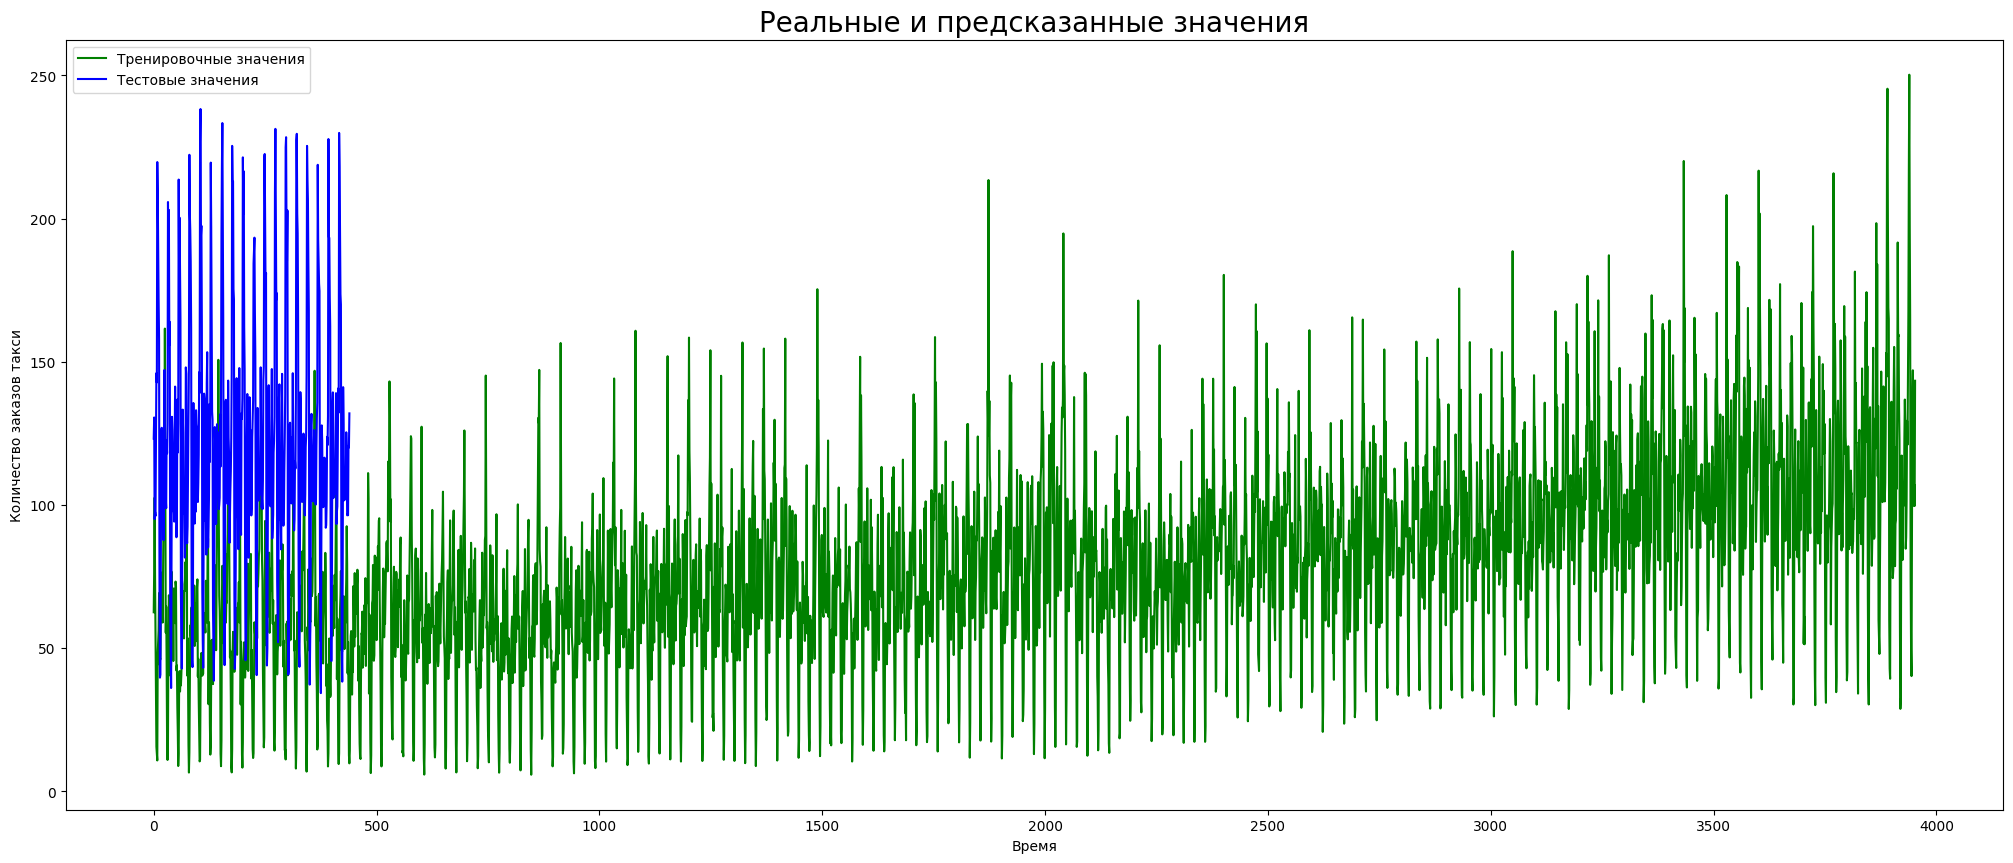

In [25]:
plt.figure(figsize=[25, 10])
plt.title('Реальные и предсказанные значения', fontsize=20)
plt.plot(pred_train, color='green', label='Тренировочные значения')
plt.plot(pred_test, color='blue', label='Тестовые значения')

plt.xlabel('Время')
plt.ylabel('Количество заказов такси')
plt.legend()
plt.show()

**Итог тестирования:**
Обучение модели соответствует требованиям - RMSE меньше 48. Считаю, что обучение прошло успешно и отдаю модель в пользование.

## Выводы

1. Были получены уже обработанные данные для работы. Без пропусков, вбросов, пробелов.
2. В данных прослеживается рост от весны к осени. Возможно, зависит от отпусков.
3. Также прослеживается сезонность за сутки - ночью такси вызывают чаще.
4. В работе использовался шаг в 1 час для прогнозирования необходимого количества такси на следующий час.
5. Для обучения были подобраны гиперпараметры для 3 моделей - простые и сложные.
6. Результаты тестирования значительно увеличили RMSE - до 44,8. Однако, это допустимый результат ошибки.
7. Обучение и тестирование прошло успешно. Моделью можно пользоваться.
